# Intro to Q-Learning

In this tutorial, you will be exposed to the basics of Q-learning by investigating a modified version of Baird's counterexample. This counterexample was originally develop to provide an example of instability in TD-learning, but we have modified it here for the setting of Q-learning.

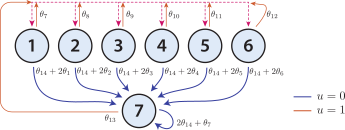

Baird's counterexample is depicted above: there are seven states ${\sf X} = \{ 1, \cdots, 7\}$ and two actions ${\sf U} = \{0,1\}$, in which $X_{k+1} = 7$ with probability one whenever $U_k=0$. If $U_k=1$ then $X_{k+1}$ is uniformly distributed over states $\{ 1,\dots, 6\}$.

In  Baird's original example, it is assumed the cost is identically zero.   We take $c(x,u) = 0$ if $x\le 6$ and $c(7,u)=-10$ (independent of $u$).


Recall from lecture that the Q-function is defined as 
$$
Q^*(x,u) = \min \sum^{\infty}_{k=0} \gamma^k \mathbb{E}[c(X_k,U_k) | X_0 = x, U_0 = u]
$$
where $\gamma \in (0,1)$ is a discounting factor.

In this tutorial, the Q-function will be linearly parameterized with dimension $d=14$, that is $Q^\theta(x,u) = \theta^T \psi(x,u)$ with $\theta \in \mathbb{R}^d$ and  

$$\psi_i(x,u)    
=
\begin{cases}  
2 \hbox{\large \bf 1}\{x=i, u=0\}
              &   1\le i\le 6
\\
 \hbox{\large \bf 1}\{x=7, u=0\}
   + \hbox{\large \bf 1}\{x=1, u=1\}
              &   i=7
\\
 \hbox{\large \bf 1}\{x+6=i, u=1\}
              &   8\le i\le 13
 \\
 \hbox{\large \bf 1}\{u=0\} [1 +  \hbox{\large \bf 1}\{x=7\}   ]           &   i=14
\end{cases} 
$$






A schematic is shown in the figure above, indicating   the following values of $Q^\theta(x,u) $:
- $ \theta_{14} + 2\theta_x$ when $(x,u) = (x,0)$,  with $1\le x\le 6$.  
- $ 2\theta_{14} +\theta_7$ when $(x,u) = (7,0)$.
- $\theta_{13} $ when $(x,u) = (7,1)$.
- $\theta_{6+x}$  when $(x,u) = (x,1)$, with $1\le x\le 6$.$1\le x\le 6$.
 discussion.

Under this parametrization, the Q-learning algorithm takes the form: for an initialization $\theta_0 \in \mathbb{R}^d$,
$$
\theta_{n+1} = \theta_{n} + \alpha_{n+1} \mathcal{D}_{n+1} \zeta_{n} \, , \qquad \zeta_{n} = \psi(X_n,U_n)
$$
$$
\mathcal{D}_{n+1} = c(X_n,U_n) + \gamma \underline{Q}^{\theta_n}(X_{n+1}) - Q^{\theta_n}(X_{n},U_n)
$$
in which $\underline{Q}(x) = \min_u Q(x,u)$ and $\{\alpha_n\}$ is a step-size sequence. 

The goal of Q-learning is then to approximate the solution of the root-finding problem:
$$
0 = \mathbb{E}[\{c(X_n,U_n) + \gamma \underline{Q}^{\theta^*}(X_{n+1}) - Q^{\theta^*}(X_{n},U_n) \}\zeta_n]
$$


$\textbf{(a)}$ The ideal behavior for the Q-learning algorithm  is $Q^{\theta_n}(x,u) \to Q^{\theta^*}(x,u)$, in which $ Q^{\theta^*}(x,u) \approx Q^*(x,u)$. Computation of $Q^*(x,u)$ for each $(x,u)$ pair is challenging in this example. However, the structure of the problem makes it particularly easy to compute when  $(x,u) = (7,0)$. What is $Q^*(7,0)$?


## Q-learning vs Relative Q-learning - Convergence

Recall from lecture that a potentially better approach is to apply *Relative Q-learning*, to estimate the relative Q-function $H^*$. The Q-function and relative Q-function differ by an additive constant as follows:
$$
H^*(x,u) = Q^*(x,u) - \frac{\delta}{1+\delta-\gamma}\langle \mu, Q^* \rangle
$$
where $\mu$ is a fixed pmf on ${\sf X} \times {\sf U}$ and $\delta>0$. Subtracting a constant from the Q-function does not change it minimizer over $u$, that is, the optimal policy $\phi^*(x) \in \arg \min_u Q^*(x,u)$. However, relative Q-learning has been shown to lead to faster convergence. 


$\textbf{(b)} $ Suppose that we select $\mu = \hbox{\large \bf 1} \{x=7,u=0\}$, that is, the point mass at state action pair $(7,0)$. This pmf was chosen due to the fact that the computation of $Q^*(7,0)$ is easy to perform. What is $H^*(7,0)$?


$\textbf{(c)}$ You are given code that implements Q-learning and Relative Q-learning for the modified Baird's counterexample with above choice of $\mu$. Run the code and discuss your findings. Is this behavior expected? What happends when you change $\delta$?


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Helper functions
def getpsi(x, u, d):
    """Baird basis function"""
    psi_new = np.zeros(d)  # Initialize the basis function vector with zeros
    for i in range(6):
        psi_new[i] = 2 * (1 - u) * (x == i + 1)  # Define the basis for states 1 to 6
    psi_new[6] = (1 - u) * (x == 7) + u * (x == 1)  # Handle basis for state 7
    for i in range(7, 13):
        psi_new[i] = u * ((x + 6) == (i + 1))  # Basis for states 8 to 13
    psi_new[13] = (1 - u) * (1 + (x == 7))  # Special handling for state 7
    return psi_new.reshape(-1, 1)  # Return the basis function as a column vector

def get_action(u_greedy, epsy, thisrand, thisobliv):
    """Epsilon-greedy action selection"""
    Greed = thisrand < (1 - epsy)  # Check if the action should be greedy (based on epsilon)
    u_obliv = thisobliv < 0.67  # Choose oblivious action with a threshold
    return Greed * u_greedy + (1 - Greed) * u_obliv  # Return greedy action or oblivious action based on epsilon

def getX(u, this_baird_rand):
    """Baird dynamics"""
    return 7 if u == 0 else this_baird_rand  # Randomly select the next state based on the action for state 7

def uQ(x, theta, d):
    """Compute Q-values and select greedy action"""
    psi_zero = getpsi(x, 0, d)  # Get the basis for action 0
    psi_one = getpsi(x, 1, d)  # Get the basis for action 1
    q_values = np.array([theta.T @ psi_zero, theta.T @ psi_one]).flatten()  # Calculate the Q-values
    u_greedy = np.argmin(q_values)  # Select the greedy action (min Q-value)
    return q_values[u_greedy], u_greedy  # Return the Q-value of the greedy action and the action itself

def get_avg_relQ(mu, theta, d):
    """Compute average of Q with respect to mu"""
    x_range = range(len(mu))  # Range of states (rows in mu)
    u_range = range(len(mu[0]))  # Range of actions (columns in mu)
    return sum(mu[x][u] * (theta.T @ getpsi(x + 1, u, d)).item() for x in x_range for u in u_range)  # Compute the weighted average Q

def run_RL(alpha, epsy, beta, C, statein, actionin, d, baird, thetaThen, delta_relQ, mu_relQ, disc, haA, explo, obliv, method):
    """Run one step of Q-learning or Relative Q-learning"""
    this_cost = C[statein - 1]  # Get the cost based on the state
    this_psi = getpsi(statein, actionin, d)  # Get the basis for the current state and action
    next_state = getX(actionin, baird)  # Get the next state based on the action
    this_Q = (thetaThen.T @ this_psi).item()  # Get the Q-value for the current state-action pair
    Q_min, u_min = uQ(next_state, thetaThen, d)  # Get the Q-value and greedy action for the next state
    upsi_greedy = getpsi(next_state, u_min, d)  # Get the basis for the greedy action at the next state
    


    # Check if the method is Q-learning or Relative Q-learning
    if method == 'Q':
    # Calculate the temporal difference (TD) error
        TD = this_cost - this_Q + disc * Q_min
        haA = haA + beta * (this_psi @ (-this_psi + disc * upsi_greedy).T - haA)  # Update the haA matrix
        update = alpha * TD * this_psi  # Update the weights
        thetaout = thetaThen + update.squeeze()  # Update the parameter vector theta
        
    elif method == 'Relative':
        haA = haA + beta * (this_psi @ (-this_psi + disc * upsi_greedy).T - haA)
        avg_muQ = get_avg_relQ(mu_relQ, thetaThen, d)  # Compute the average Q using mu
        TD = this_cost - this_Q + disc * Q_min - delta_relQ * avg_muQ  # Update TD for Relative Q-learning
        update = alpha * TD * this_psi
        thetaout = thetaThen + update.squeeze()

    # Calculate the greedy action for the next state
    _, u_min = uQ(next_state, thetaout, d)
    next_action = get_action(u_min, epsy, explo, obliv)  # Get the next action based on epsilon-greedy

    # Compute the optimal Q-value for the next state-action pair
    psiBest = getpsi(7, 0, d)
    QoptOut = (thetaout.T @ psiBest).item()

    return thetaout, QoptOut, next_state, next_action, haA


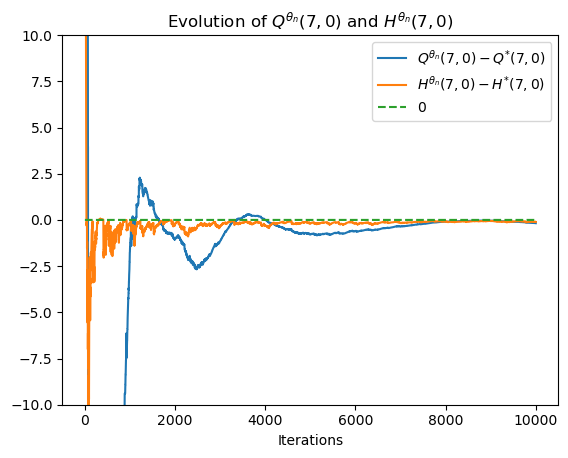

In [3]:
# Baird's Counterexample Q-learning

np.random.seed(2)  # Set the random seed for reproducibility

# Define constants related to the problem
num_states = 7
num_actions = 2
d = num_states * num_actions  # Number of features in the basis function
Hor = int(1e4)  # Number of episodes (or iterations)

disc = 0.95  # Discount factor
epsyFinal = 0.5  # Epsilon for exploration in epsilon-greedy

# Reward vector (state-based reward)
R = np.array([0, 0, 0, 0, 0, 0, 10])
C = -R  # Cost is the negative of the reward

LowestQ = C[6] / (1 - disc)  # Calculate the lowest possible Q-value

# Step-size parameters (for alpha and beta)
g = 1 / (1 - disc)
rho = 0.85
alphaAll = g * np.arange(1, Hor + 1).astype(float) ** (-rho)
alphaAll = np.minimum(alphaAll, 0.1)  # Cap alpha to 0.1
alphaAll_Zap = g * np.arange(1, Hor + 1).astype(float) ** (-1)
alphaAll_Zap = np.minimum(alphaAll_Zap, 0.1)  # Cap alpha to 0.1 for "Zap" method
betaAll = g * np.arange(1, Hor + 1).astype(float) ** (-rho)
betaAll = np.minimum(betaAll, 0.1)  # Cap beta to 0.1

# Initialize theta
thetaAll_Q = np.zeros((d, Hor))
thetaIC = np.random.rand(d, 1) / (1 - disc)  # Initialize theta for Q-learning
thetaNow = thetaIC
thetaAll_Q[:, 0] = thetaNow.flatten()  # Set the initial theta value

thetaAll_relQ = np.copy(thetaAll_Q)  # Copy the theta for Relative Q-learning

# Initialize matrices for Q-learning and Relative Q-learning
this_haA_Q = np.zeros((d, d))
this_haA_relQ = np.zeros((d, d))

QoptAll_Q = np.zeros(Hor)
QoptAll_relQ = np.zeros(Hor)

# Transition matrices (not explicitly used in your code, but initialized for completeness)
T0 = np.zeros((num_states, num_states))
T0[:, 6] = np.ones(7)

T1 = np.ones((num_states, num_states)) / 6
T1[:, 6] = np.zeros(7)

# Initial state and action
stateIC = np.random.randint(1, num_states + 1)  # Start in a random state
actionIC = np.random.randint(0, num_actions)  # Start with a random action

#delta for Relative Q
delta_relQ=0.2

psi = np.random.rand(d, 1)
#PMF Mu for Relative Q Learning (\mu(x,u)) -- rows represent states (1 through 7) and columns inputs (0,1))
mu_relQ = [
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [1, 0],
]

# Exploration and oblivion vectors
explo_vec = np.random.uniform(0, 1, Hor)
obliv_vec = np.random.uniform(0, 1, Hor)
baird_vec = np.random.randint(1, 7, Hor)

# Initial states and actions for both Q-learning and Relative Q-learning
this_state_Q = stateIC
this_action_Q = actionIC
this_state_relQ = stateIC
this_action_relQ = actionIC

# Main loop for learning
for n in range(Hor):
    # Update parameters for each iteration
    alpha = alphaAll[n]
    beta = betaAll[n]
    epsy = epsyFinal

    # Perform Q-learning
    thetaAll_Q[:, n], QoptAll_Q[n], next_state_Q, next_action_Q, next_haA_Q = run_RL(
        alpha, epsy, beta, C, this_state_Q, this_action_Q, d, baird_vec[n], thetaAll_Q[:, n - 1],
        delta_relQ, mu_relQ, disc, this_haA_Q, explo_vec[n], obliv_vec[n], 'Q'
    )

    # Perform Relative Q-learning
    thetaAll_relQ[:, n], QoptAll_relQ[n], next_state_relQ, next_action_relQ, next_haA_relQ = run_RL(
        alpha, epsy, beta, C, this_state_relQ, this_action_relQ, d, baird_vec[n], thetaAll_relQ[:, n - 1],
        delta_relQ, mu_relQ, disc, this_haA_relQ, explo_vec[n], obliv_vec[n], 'Relative'
    )

    # Update the state and action for the next iteration
    this_state_Q = next_state_Q
    this_action_Q = next_action_Q
    this_haA_Q = next_haA_Q.copy()

    this_state_relQ = next_state_relQ
    this_action_relQ = next_action_relQ
    this_haA_relQ = next_haA_relQ.copy()

# Plotting results
plt.figure(1)
plt.plot(QoptAll_Q - LowestQ, label=r"$Q^{\theta_n}(7,0) - Q^{*}(7,0)$")  # Plot Q-learning
plt.plot(QoptAll_relQ - LowestQ + delta_relQ * LowestQ / (1 + delta_relQ - disc), label=r"$H^{\theta_n}(7,0) - H^{*}(7,0)$")  # Plot Relative Q-learning
plt.plot(0 * np.ones_like(QoptAll_Q), '--', label="0")  # Plot zero line
plt.legend()
plt.ylim([-10, 10])
plt.title(r'Evolution of $Q^{\theta_n}(7,0)$ and $H^{\theta_n}(7,0)$')
plt.xlabel(r'Iterations')
plt.show()

## Q-learning vs Relative Q-learning - Asymptotic Statistics


$\textbf{(d)}$ You are given code that performs $M$ independent runs for the same problem in part (c). Moreover, the code creates histograms for the scaled errors $\{  \sqrt{N}  (\theta^{\text{\sf PR}^i}_N - \theta^*) : 1 \leq  i \leq  M \}$ and $\{  \sqrt{N}  (\theta^{i}_N - \theta^*) : 1 \leq  i \leq  M \}$ and computes the empirical variances for $\{  \sqrt{N}  (\theta^{\text{\sf PR}^i}_N - \theta^*) : 1 \leq  i \leq  M \}$ and $\{  \sqrt{\alpha^{-1}_N}  (\theta^{i}_N - \theta^*) : 1 \leq  i \leq  M \}$.

Run the code and discuss your findings. Can you select $\mu$ so that the empirical covariance is minimized?


In [4]:

# Baird's Counterexample Q-learning

start_time = time.time()

np.random.seed(2)

num_states = 7
num_actions = 2
d = num_states * num_actions  # In Baird's example

# Number of episodes
Hor = int(1e4)

#Number of repeated runs
M=300

disc = 0.95  # Discount factor

epsyFinal = 0.5  # Epsilon-greedy exploration
#epsyAll = np.arange(1, Hor + 1) ** (-0.2)
#epsyAll = np.maximum(epsyAll, epsyFinal)

# Define the reward vector, depending only on the state
R = np.array([0, 0, 0, 0, 0, 0, 10])
C = -R  # Stick to notation in the paper

LowestQ = C[6] / (1 - disc)

# Step-size parameters
g = 1 / (1 - disc)
rho = 0.85

alphaAll = g * np.arange(1, Hor + 1) ** (-rho)
alphaAll = np.minimum(alphaAll, 0.1)



betaAll = g * np.arange(1, Hor + 1) ** (-0.6)
betaAll = np.minimum(betaAll, 0.1)


this_haA_Q = np.zeros((d, d))

this_haA_relQ = np.zeros((d, d))

this_haA_Zap = np.zeros((d, d))

# Initialize theta
thetaAll_Q = np.zeros((d, Hor,M))

thetaIC= np.random.rand(d,M) / (1 - disc)
thetaAll_Q[:, 0,:] = thetaIC #.flatten()

thetaAll_Zap = np.zeros((d, Hor,M))

thetaAll_relQ = np.zeros((d, Hor,M))

thetaPR_Q = np.zeros((d,M))

thetaPR_relQ = np.zeros((d,M))

thetaPR_Zap = np.zeros((d,M))

QoptAll_Q = np.zeros((Hor,M)) #Q(7,0) for Q learning

QoptAll_Zap = np.zeros((Hor,M)) #Q(7,0) for Zap Q learning

QoptAll_relQ = np.zeros((Hor,M)) #Q(7,0) for Relative Q learning 

# Define the transition matrices (not used explicitly)
T0 = np.zeros((num_states, num_states))
T0[:, 6] = np.ones(7)

T1 = np.ones((num_states, num_states)) / 6
T1[:, 6] = np.zeros(7)

stateIC = np.random.randint(1, num_states + 1,M)  # Start in a random state
actionIC = np.random.randint(0, num_actions,M)  # Start in a random action (0 or 1)

delta_relQ = 0.2 # Delta for Relative Q learning


#PMF Mu for Relative Q Learning (\mu(x,u)) -- rows represent states (1 through 7) and columns inputs (0,1))

mu_relQ =  [
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [1, 0],
]




#Get exploration vectors for the entire run
explo_vec = np.random.uniform(0,1,(Hor,M)) #Epsilon-greedy Randomization
obliv_vec = np.random.uniform(0,1,(Hor,M)) #Oblivious Policy Randomization
baird_vec = np.random.randint(1, 7,(Hor,M)) # Randomization at 7th state



for m in range(M):  # Independent runs
    
    # Independent initialization for each run
    thetaIC = np.random.rand(d) / (1 - disc)  # Generate new initial theta for each run
    thetaAll_Q[:, 0, m] = thetaIC
    thetaAll_relQ[:, 0, m] = thetaIC
    #thetaAll_Zap[:, 0, m] = thetaIC


    this_state_Q = stateIC[m] #initial state for Q learning
    this_action_Q = actionIC[m] #initial action for Q learning

    this_state_relQ = stateIC[m] #initial state for relative Q learning
    this_action_relQ = actionIC[m]  #initial action for relative Q learning

   # this_state_Zap = stateIC[m]
   # this_action_Zap = actionIC[m]



    # Main Q-learning loop (Independent)
    for n in range(Hor):

        alpha = alphaAll[n]
        beta = betaAll[n]
        epsy = epsyFinal
    
          #Run Q learning
        thetaAll_Q[:,n,m], QoptAll_Q[n,m],next_state_Q,next_action_Q,next_haA_Q = run_RL(
            alpha,epsy,beta,C,this_state_Q,this_action_Q,d,baird_vec[n,m],thetaAll_Q[:,n-1,m],
            delta_relQ,mu_relQ,disc,this_haA_Q,explo_vec[n,m],obliv_vec[n,m],'Q'
        )
    
            #Run Relative Q learning
        thetaAll_relQ[:,n,m], QoptAll_relQ[n,m],next_state_relQ,next_action_relQ,next_haA_relQ= run_RL(
            alpha,epsy,beta,C,this_state_relQ,this_action_relQ,d,baird_vec[n,m],thetaAll_relQ[:,n-1,m],
            delta_relQ,mu_relQ,disc,this_haA_relQ,explo_vec[n,m],obliv_vec[n,m],'Relative'
        )

        this_state_Q = next_state_Q
        this_action_Q = next_action_Q
        this_haA_Q = next_haA_Q
    
        this_state_relQ = next_state_relQ
        this_action_relQ = next_action_relQ
        this_haA_relQ = next_haA_relQ
        
   
        
        
        
    thetaPR_Q[:,m] = np.mean(thetaAll_Q[:, int(0.7*Hor):Hor, m], axis=1)

    thetaPR_relQ[:,m] = np.mean(thetaAll_relQ[:, int(0.7*Hor):Hor, m], axis=1)

    
    
    
    

print("Execution Time:", time.time() - start_time)


Execution Time: 4.802562236785889


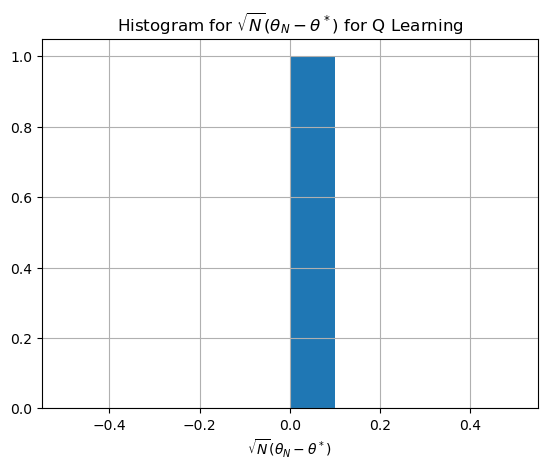

<IPython.core.display.Math object>

0.0


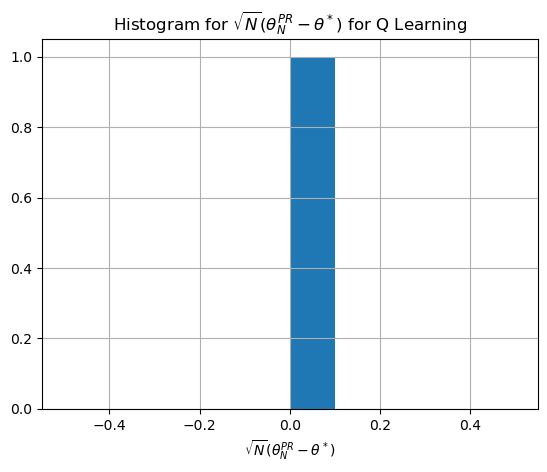

<IPython.core.display.Math object>

0.0


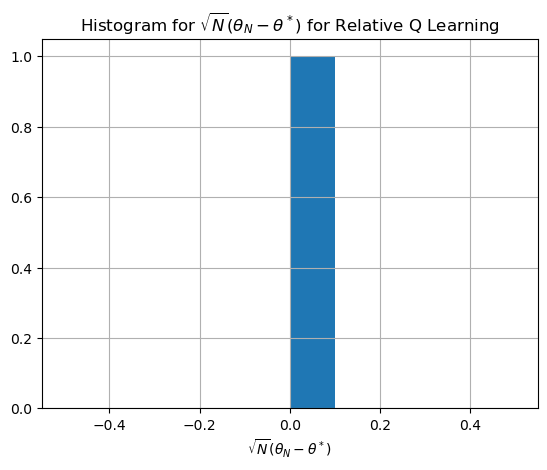

<IPython.core.display.Math object>

0.0


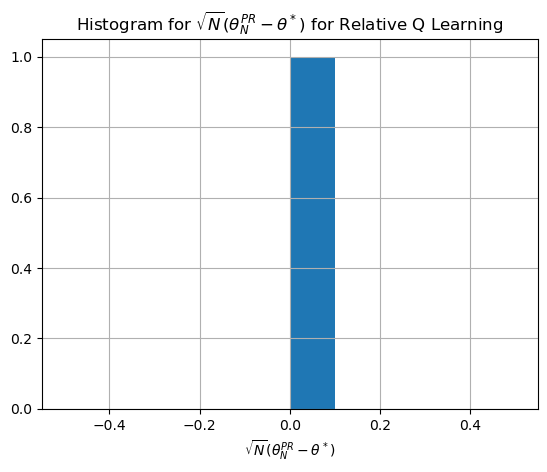

<IPython.core.display.Math object>

0.0


In [5]:
from IPython.display import display, Math
    
#Vanilla Q
#hist of theta
plt.hist(np.sqrt(Hor)*(thetaAll_Q[13,-1,:] -  np.mean(thetaAll_Q[13,-1,:])  ))
plt.xlabel(r'$\sqrt{N}(\theta_N - \theta^*)$')
plt.title(r'Histogram for $\sqrt{N}(\theta_N - \theta^*)$ for Q Learning')
plt.grid()
plt.show()

display(Math(r"\text{The empirical variance for } \sqrt{\alpha_N^{-1}}(\theta_N - \theta^*) \text{ in Q-learning is}"))
print(np.var(np.sqrt(Hor**rho)*(thetaAll_Q[13,-1,:] -  np.mean(thetaAll_Q[13,-1,:]) )))


#hist of thetaPR
plt.hist(np.sqrt(Hor)*(thetaPR_Q[13,:] - np.mean(thetaPR_Q[13,:]) ))
plt.xlabel(r'$\sqrt{N}(\theta^{PR}_N - \theta^*)$')
plt.title(r'Histogram for $\sqrt{N}(\theta^{PR}_N - \theta^*)$ for Q Learning')
plt.grid()
plt.show()

display(Math(r"\text{The empirical variance for } \sqrt{N}(\theta^{PR}_N - \theta^*) \text{ in Q-learning is}"))
print(np.var(np.sqrt(Hor)*(thetaPR_Q[13,:]) - np.mean(thetaPR_Q[13,:])))


#Relative Q
#hist of theta
plt.hist(np.sqrt(Hor)*(thetaAll_relQ[13,-1,:] - np.mean(thetaAll_relQ[13,-1,:])   ))
plt.xlabel(r'$\sqrt{N}(\theta_N - \theta^*)$')
plt.title(r'Histogram for $\sqrt{N}(\theta_N - \theta^*)$ for Relative Q Learning')
plt.grid()
plt.show()

display(Math(r"\text{The empirical variance for } \sqrt{\alpha_N^{-1}}(\theta_N - \theta^*) \text{ in relative Q-learning is}"))
print(np.var(np.sqrt(Hor**rho)*(thetaAll_relQ[13,-1,:] -  np.mean(thetaAll_relQ[13,-1,:]) )))


#hist of thetaPR
plt.hist(np.sqrt(Hor)*(thetaPR_relQ[13,:]  - np.mean(thetaPR_relQ[13,:])  ))
plt.xlabel(r'$\sqrt{N}(\theta^{PR}_N - \theta^*)$')
plt.title(r'Histogram for $\sqrt{N}(\theta^{PR}_N - \theta^*)$ for Relative Q Learning')
plt.grid()
plt.show()

display(Math(r"\text{The empirical variance for } \sqrt{N}(\theta^{PR}_N - \theta^*) \text{ in relative Q-learning is}"))
print(np.var(np.sqrt(Hor)*(thetaPR_relQ[13,:]) - np.mean(thetaPR_relQ[13,:])))





